<a href="https://colab.research.google.com/github/paolitacute/Computer-Vision-Project-3/blob/main/ImageDescription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Triplet loss**

- https://docs.pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html

$$
L = \max(d(f(x_a),f(x_p)) - d(f(x_a),f(x_n)) + m, 0)
$$

where $m$ is a margin of safety, $f(x)$ is the descriptor for image $x$ normalized as a unit vector, and $d(a,b)$ is the distance between descriptors $a$ and $b$.

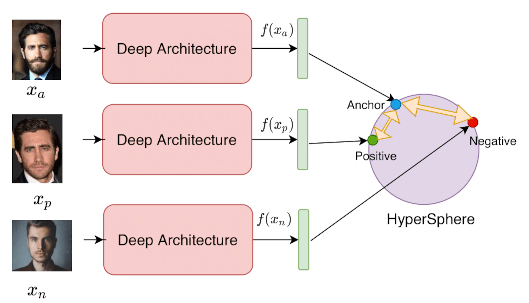

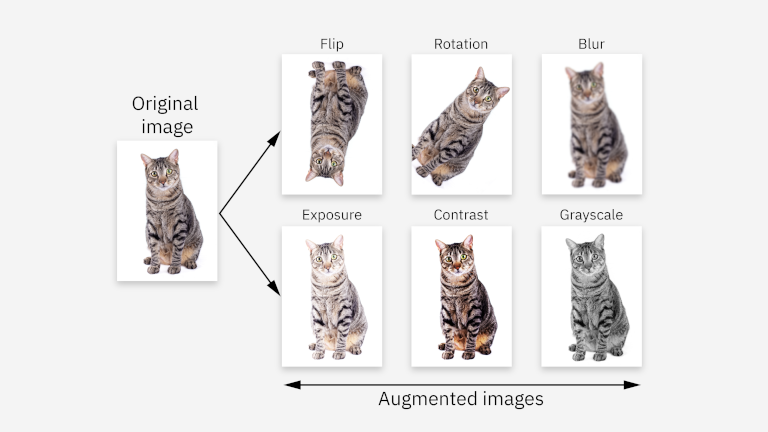

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torchvision
import numpy as np
import torch

In [ ]:
face_augmentation = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomResizedCrop((64,64), (0.8,1.0), (0.9,1.1)),
    torchvision.transforms.ColorJitter(0.1,0.1,0.1,0.1)
)

In [ ]:
class FaceDataset(torch.utils.data.Dataset):
  def __init__(self, ids=None, aug=None):
    faces = fetch_olivetti_faces()
    if ids is None:
      ids = np.unique(faces.target)

    self.aug = aug if aug is not None else torch.nn.Sequential()

    indices = []
    for i in ids:
      indices += list(np.where(faces.target == i)[0])

    x = faces.images[indices]
    n, h, w = x.shape
    self.x = (x.reshape(n, 1, h, w)*255.0).astype(np.uint8)
    self.y = faces.target[indices]

    self.indices = {i:[] for i in ids}
    for i,j in enumerate(self.y):
      self.indices[j].append(i)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    # anchor
    x1 = (np.asarray(self.aug(Image.fromarray(self.x[idx,0])))/255.0)[np.newaxis].astype(np.float32)

    # positive
    label = self.y[idx]
    indices = self.indices[label]
    pos_idx = indices[torch.randint(0, len(indices), (1,)).item()]
    while pos_idx == idx:
      pos_idx = indices[torch.randint(0, len(indices), (1,)).item()]

    x2 = (np.asarray(self.aug(Image.fromarray(self.x[pos_idx,0])))/255.0)[np.newaxis].astype(np.float32)

    # negative
    labels = [key for key in self.indices.keys()]
    neg_label = labels[torch.randint(0, len(self.indices), (1,)).item()]
    while neg_label == label:
      neg_label = labels[torch.randint(0, len(self.indices), (1,)).item()]
    indices = self.indices[neg_label]
    neg_idx = indices[torch.randint(0, len(indices), (1,)).item()]

    x3 = (np.asarray(self.aug(Image.fromarray(self.x[neg_idx,0])))/255.0)[np.newaxis].astype(np.float32)

    return x1, x2, x3 #anchor, positive, negative

In [ ]:
def equal_error_rate(genuine, impostor):
    genuine = np.array(genuine)
    impostor = np.array(impostor)

    thresholds = np.linspace(min(min(genuine), min(impostor)), max(max(genuine), max(impostor)), 1000)

    false_acceptance_rates = []
    false_rejection_rates = []

    for threshold in thresholds:
        false_acceptance_rates.append(np.sum(impostor <= threshold) / len(impostor))
        false_rejection_rates.append(np.sum(genuine > threshold) / len(genuine))

    eer = thresholds[np.argmin(np.abs(np.array(false_acceptance_rates) - np.array(false_rejection_rates)))]
    return ((np.sum(impostor <= eer) / len(impostor)) + (np.sum(genuine > threshold) / len(genuine)))/2.0

300 100


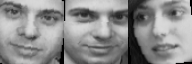


123.71128845214844 268.5870361328125


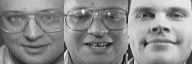

127.23590087890625 132.37460327148438


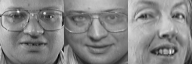

122.40065002441406 135.35948181152344


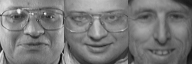

98.07099914550781 239.59620666503906


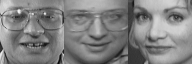

110.72209167480469 282.45513916015625


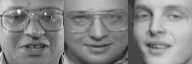

129.55418395996094 136.74212646484375


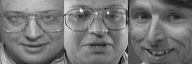

23.6435546875 114.96327209472656


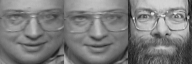

127.44491577148438 130.05899047851562


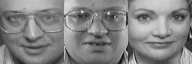

117.0860366821289 133.72152709960938


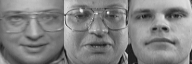

39.689048767089844 154.2801513671875


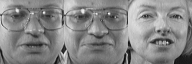

62.980812072753906 156.15335083007812


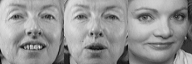

113.89531707763672 245.06874084472656


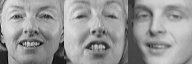

110.11328887939453 172.10733032226562


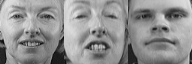

70.28617095947266 228.8839874267578


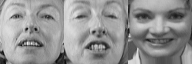

76.22634887695312 175.22999572753906


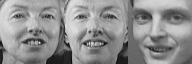

110.11328887939453 211.14480590820312


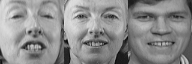

114.8620376586914 288.9587097167969


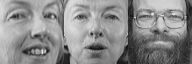

50.773887634277344 158.88113403320312


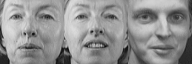

62.980812072753906 264.2884216308594


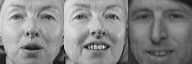

74.88606262207031 163.97091674804688


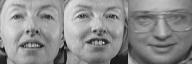

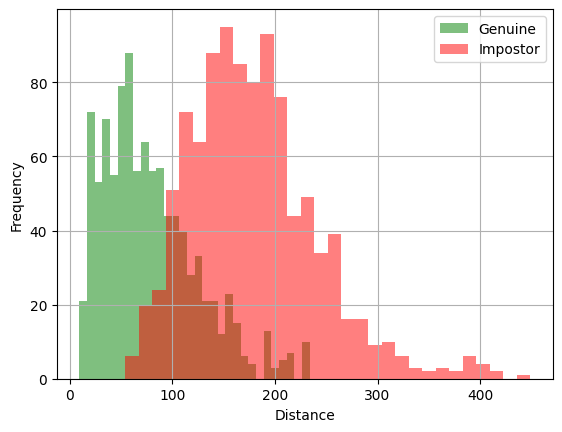

EER: 0.0875


In [ ]:
train_dataset = FaceDataset([i for i in range(30)], face_augmentation)
test_dataset = FaceDataset([i for i in range(30,40)], torch.nn.Sequential())
print(len(train_dataset), len(test_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

for x, y, z in train_dataloader:
  cv2_imshow(np.concatenate((x[0,0].numpy(), y[0,0].numpy(), z[0,0].numpy()), axis=1)*255.0)
  break

print()

genuine = []
impostor = []
for j in range(10):
  for i, (x, y, z) in enumerate(test_dataloader):
    genuine.append(torch.sum((x-y)**2).item())
    impostor.append(torch.sum((x-z)**2).item())
    if j == 0 and i < 20:
      print(genuine[-1], impostor[-1])
      cv2_imshow(np.concatenate((x[0,0].numpy(), y[0,0].numpy(), z[0,0].numpy()), axis=1)*255.0)

plt.hist(genuine, bins=30, alpha=0.5, label='Genuine', color='green')
plt.hist(impostor, bins=30, alpha=0.5, label='Impostor', color='red')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

print('EER:', equal_error_rate(genuine, impostor))

In [ ]:
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
markers = ['x', '+', 'o', 's', '^']

99 0.21122989058494568


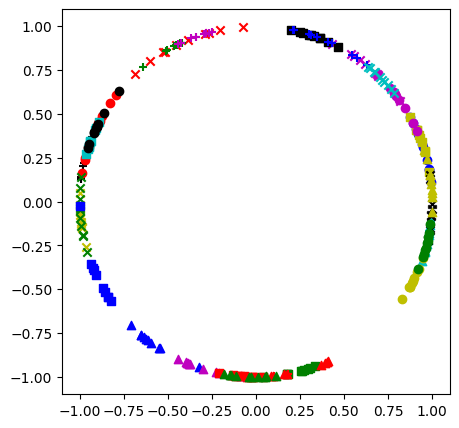

199 0.20463373760382333


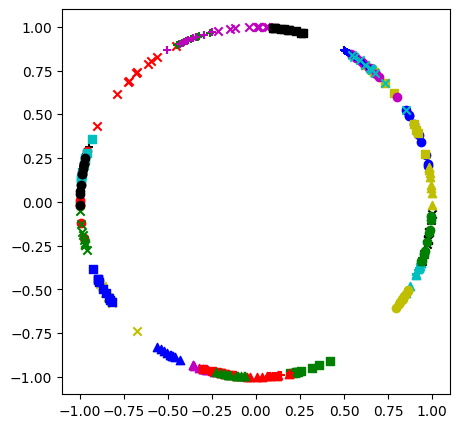

299 0.21400930235783258


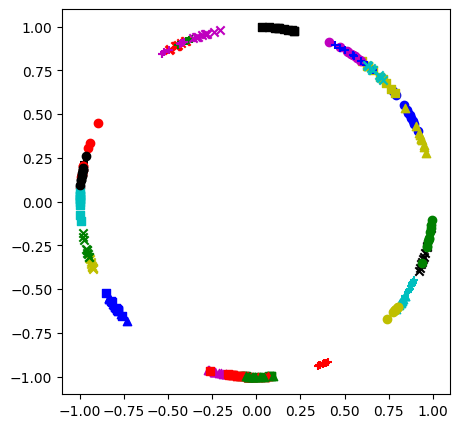

399 0.1561960205435753


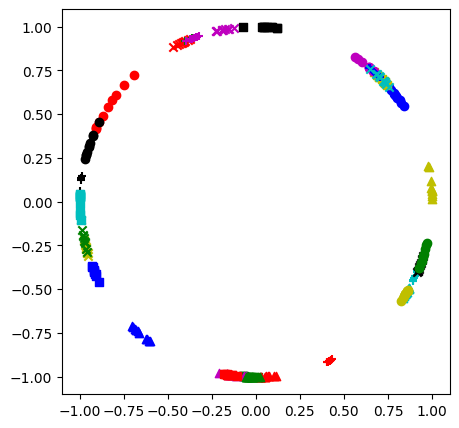

499 0.17621295899152756


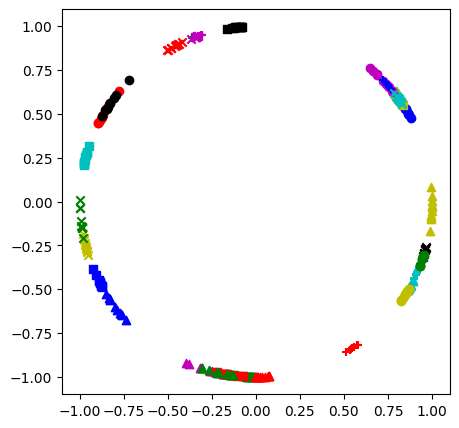

599 0.14502499749263129


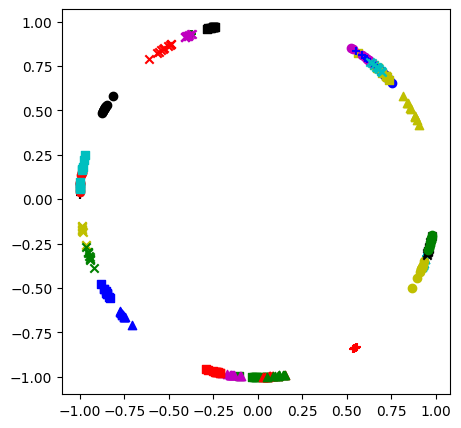

699 0.12786240875720978


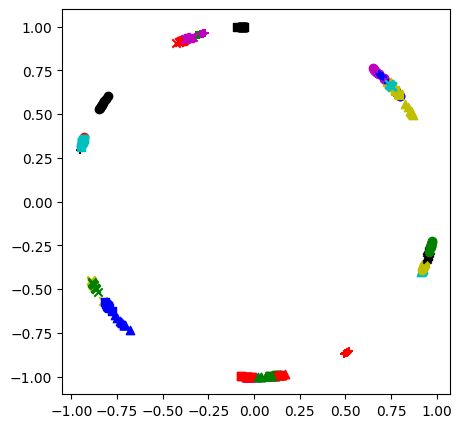

799 0.16354516272743544


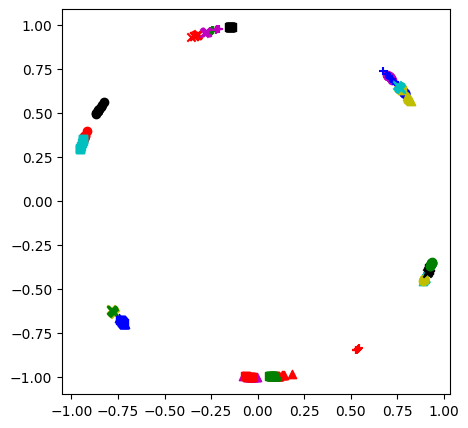

899 0.16605539123217264


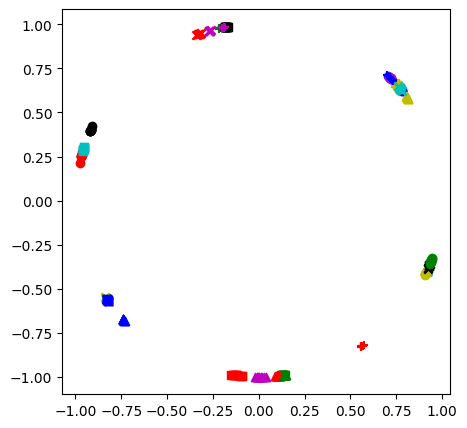

999 0.13637354224920273


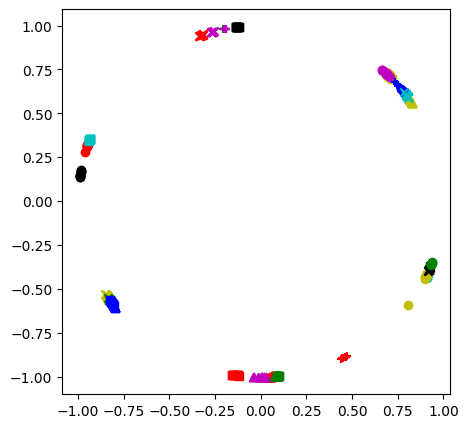

In [ ]:
model = torchvision.models.resnet.resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
model = model.cuda()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50, num_workers=2, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

triplet_loss = torch.nn.TripletMarginLoss(margin=1.0)

for epoch in range(1000):
  loss_sum = 0
  model.train()
  for x, y, z in train_dataloader:
    x = torch.cat((x,x,x), dim=1).cuda()
    y = torch.cat((y,y,y), dim=1).cuda()
    z = torch.cat((z,z,z), dim=1).cuda()

    optimizer.zero_grad()

    feat_x = torch.nn.functional.normalize(model(x), p=2.0, dim=1)
    feat_y = torch.nn.functional.normalize(model(y), p=2.0, dim=1)
    feat_z = torch.nn.functional.normalize(model(z), p=2.0, dim=1)

    loss = triplet_loss(feat_x, feat_y, feat_z)
    loss_sum += loss.item()*len(x)

    loss.backward()
    optimizer.step()
  loss_sum /= len(train_dataset)

  if epoch%100 == 99:
    print(epoch, loss_sum)
    model.eval()
    plt.figure(figsize=(5, 5))
    for key,val in train_dataset.indices.items():
      x = torch.from_numpy((train_dataset.x[val]/255.0).astype(np.float32))
      x = torch.cat((x,x,x), dim=1).cuda()
      with torch.no_grad():
        feat_x = torch.nn.functional.normalize(model(x), p=2.0, dim=1).cpu().numpy()
      plt.scatter(feat_x[:,0], feat_x[:,1], c=colors[key%len(colors)], marker=markers[key%len(markers)])
    plt.show()

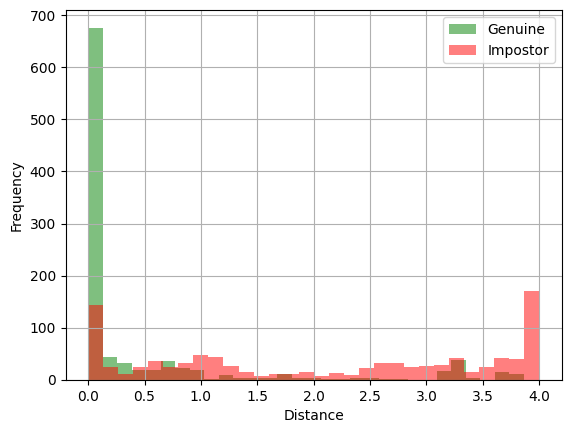

EER: 0.108


In [ ]:
genuine = []
impostor = []
for j in range(10):
  for i, (x, y, z) in enumerate(test_dataloader):
    x = torch.cat((x,x,x), dim=1).cuda()
    y = torch.cat((y,y,y), dim=1).cuda()
    z = torch.cat((z,z,z), dim=1).cuda()

    with torch.no_grad():
      feat_x = torch.nn.functional.normalize(model(x), p=2.0, dim=1)
      feat_y = torch.nn.functional.normalize(model(y), p=2.0, dim=1)
      feat_z = torch.nn.functional.normalize(model(z), p=2.0, dim=1)

    genuine.append(torch.sum((feat_x-feat_y)**2).item())
    impostor.append(torch.sum((feat_x-feat_z)**2).item())

plt.hist(genuine, bins=30, alpha=0.5, label='Genuine', color='green')
plt.hist(impostor, bins=30, alpha=0.5, label='Impostor', color='red')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

print('EER:', equal_error_rate(genuine, impostor))

Epoch: 9 / Loss: 0.40426672001679737


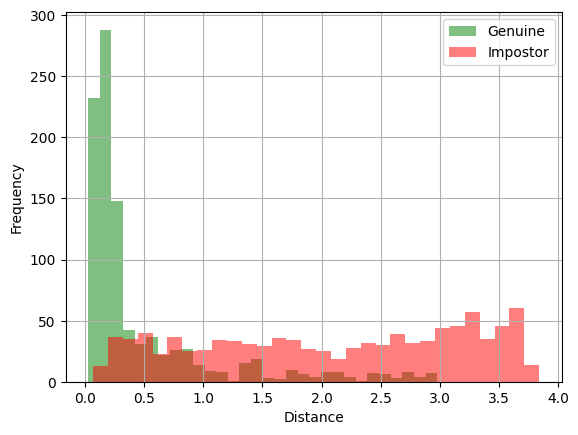

EER: 0.0885
Epoch: 19 / Loss: 0.24707977225383124


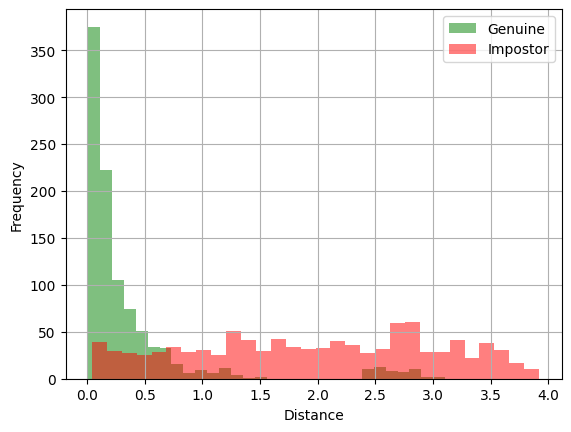

EER: 0.068
Epoch: 29 / Loss: 0.15349717934926352


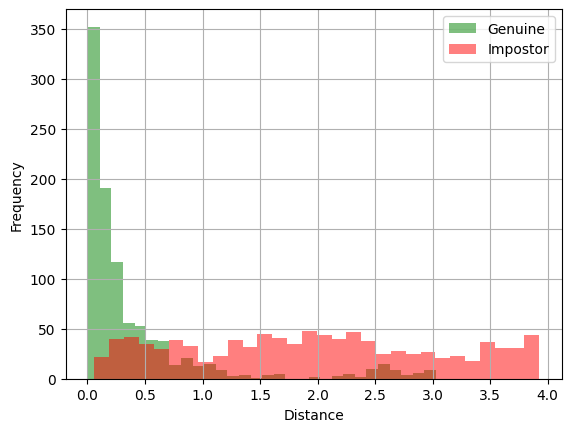

EER: 0.082
Epoch: 39 / Loss: 0.17319791143139204


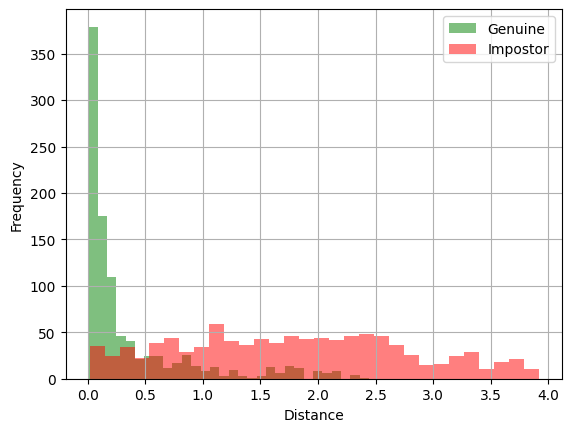

EER: 0.085
Epoch: 49 / Loss: 0.16319974263509116


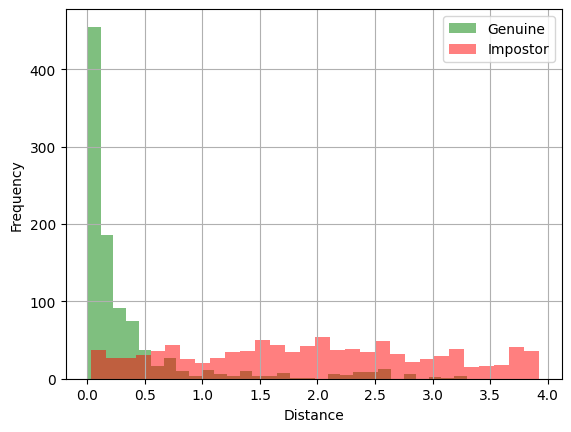

EER: 0.0725
Epoch: 59 / Loss: 0.13177872573335966


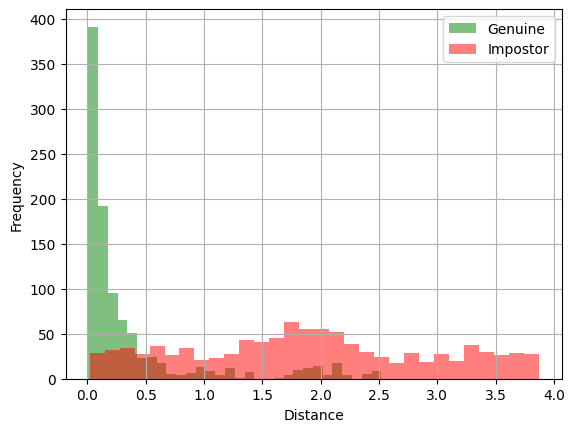

EER: 0.0755
Epoch: 69 / Loss: 0.10237820446491241


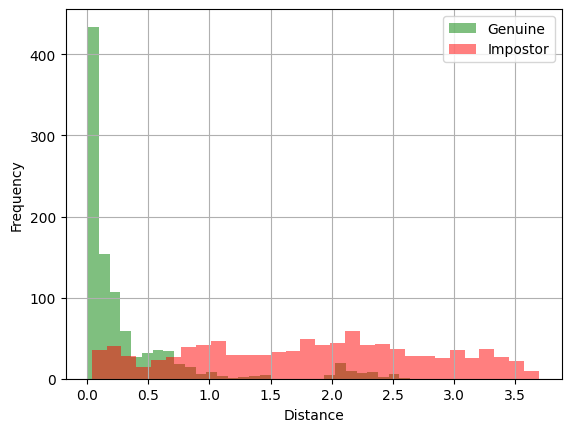

EER: 0.07
Epoch: 79 / Loss: 0.12394122406840324


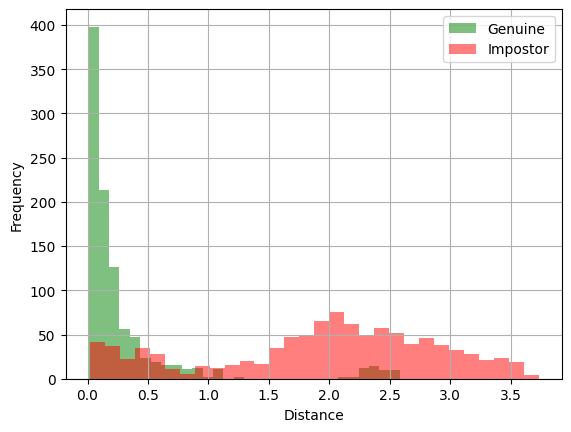

EER: 0.068
Epoch: 89 / Loss: 0.08447586745023727


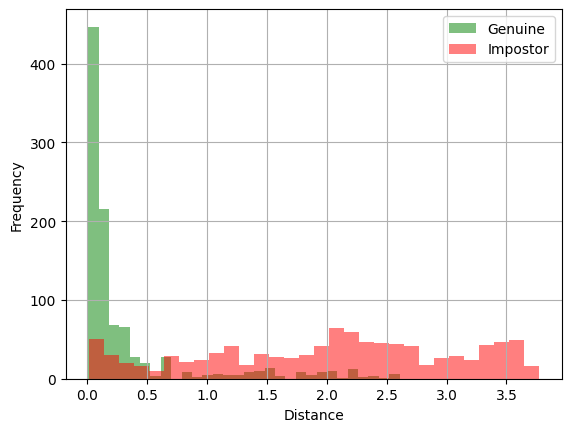

EER: 0.0655
Epoch: 99 / Loss: 0.10708556820948918


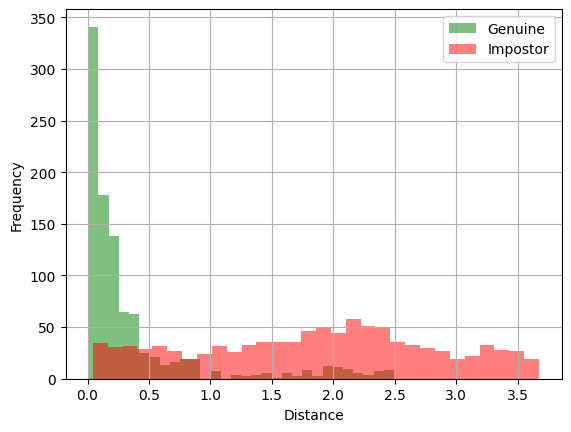

EER: 0.0785
Epoch: 109 / Loss: 0.09246489405632019


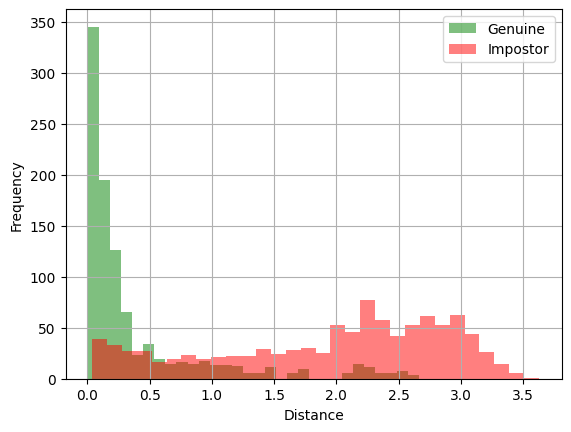

EER: 0.0835
Epoch: 119 / Loss: 0.08128349234660466


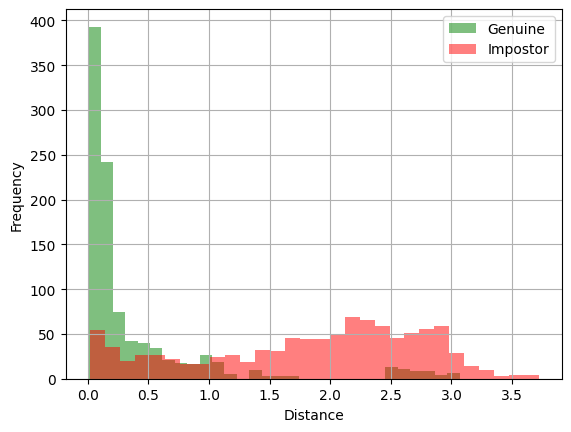

EER: 0.0825
Epoch: 129 / Loss: 0.047106074479719005


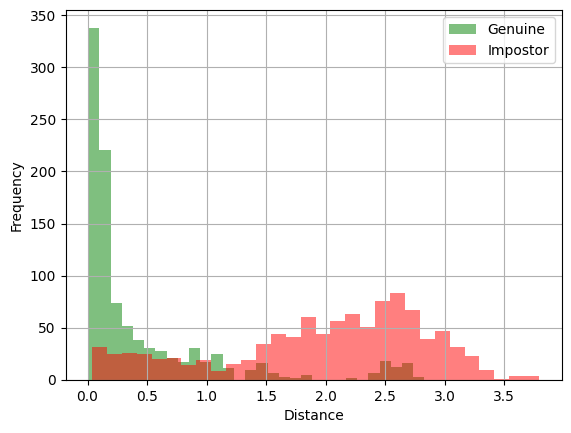

EER: 0.0805
Epoch: 139 / Loss: 0.07550967329492171


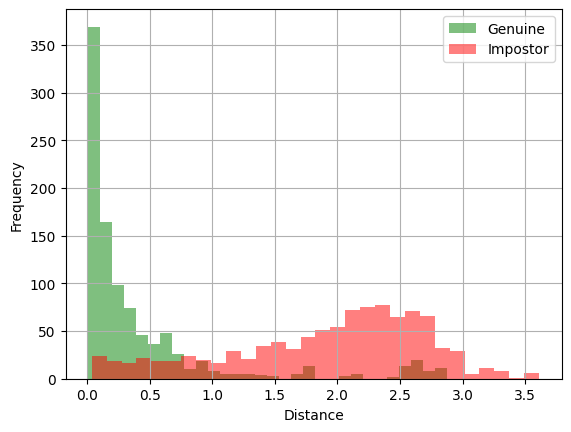

EER: 0.066
Epoch: 149 / Loss: 0.06209431650737921


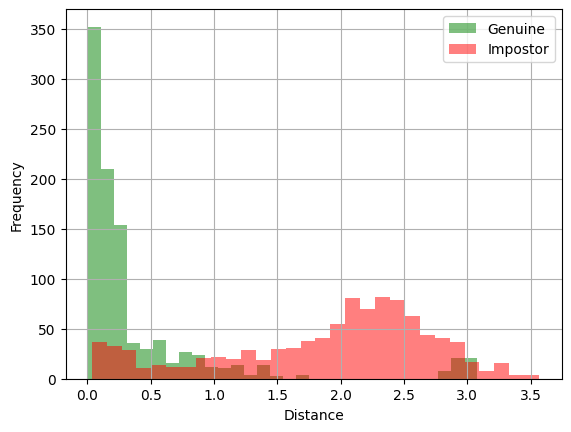

EER: 0.072
Epoch: 159 / Loss: 0.05714652128517628


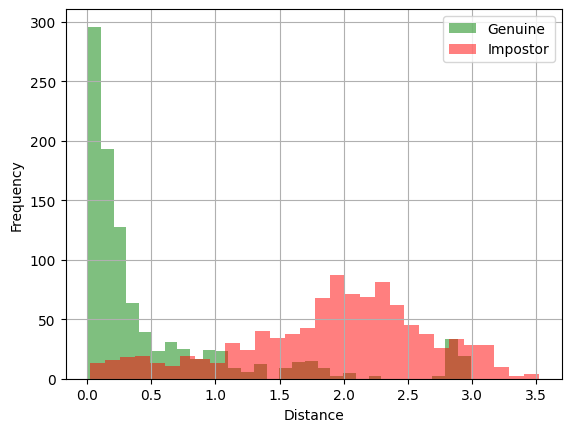

EER: 0.072
Epoch: 169 / Loss: 0.04123506089672446


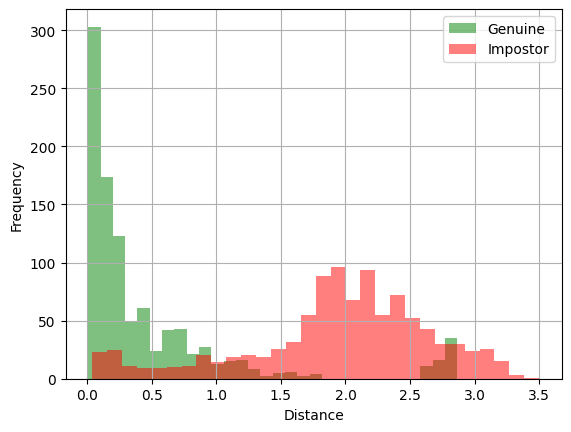

EER: 0.062
Epoch: 179 / Loss: 0.05275054431209961


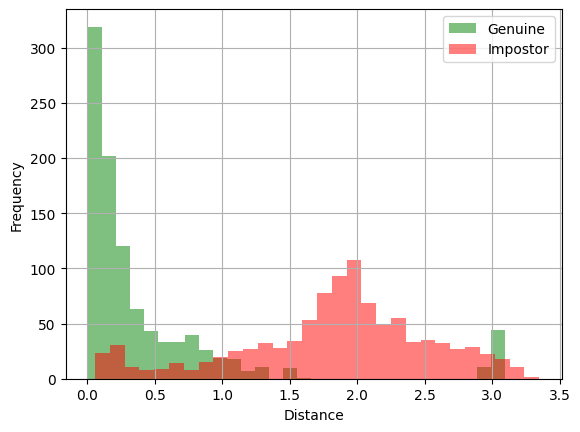

EER: 0.06
Epoch: 189 / Loss: 0.03358253464102745


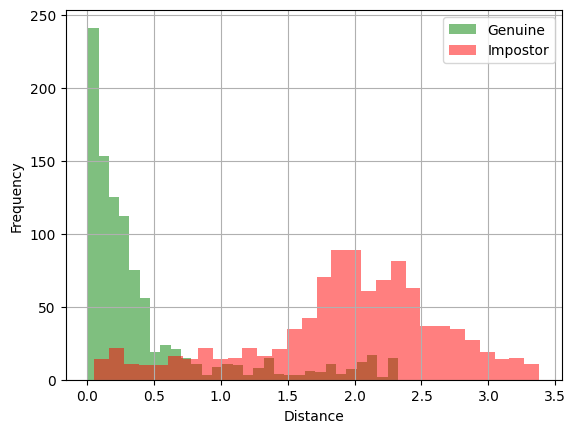

EER: 0.0665
Epoch: 199 / Loss: 0.040790391620248556


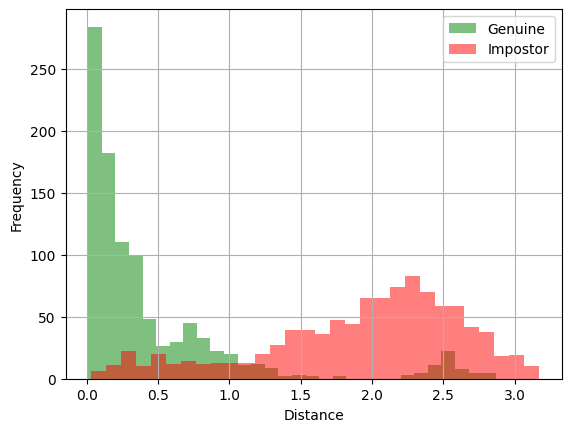

EER: 0.06
Epoch: 209 / Loss: 0.03311552739857385


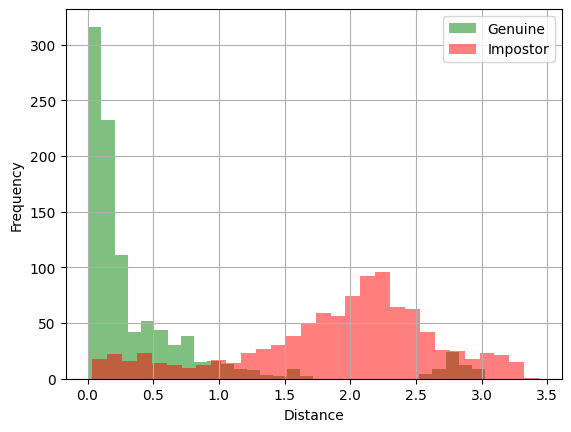

EER: 0.0615
Epoch: 219 / Loss: 0.021327802542752277


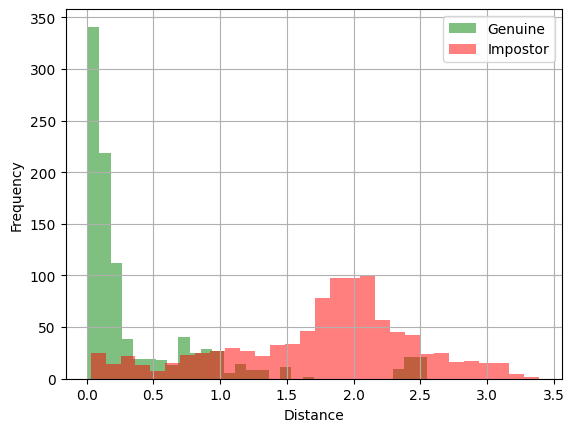

EER: 0.067
Epoch: 229 / Loss: 0.0374945771570007


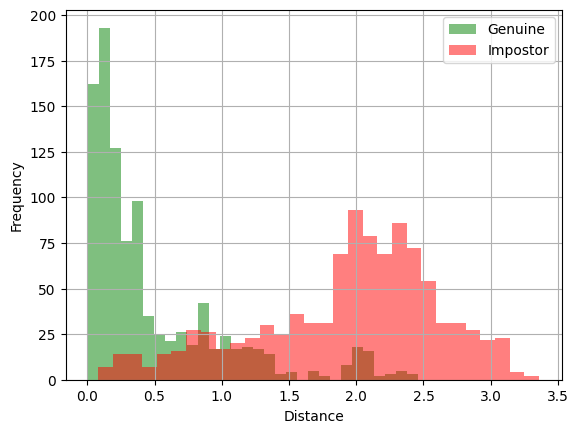

EER: 0.0685
Epoch: 239 / Loss: 0.01860147442979117


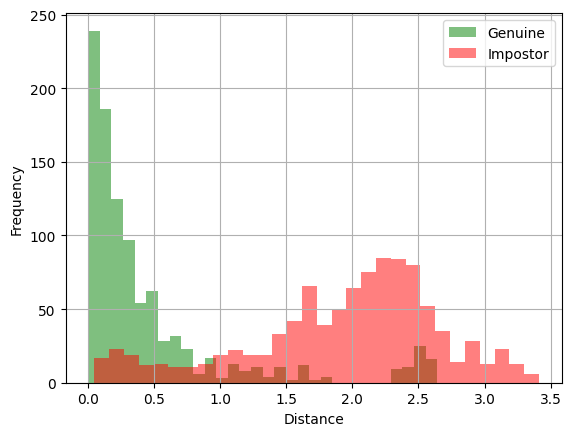

EER: 0.065
Epoch: 249 / Loss: 0.027578915779789288


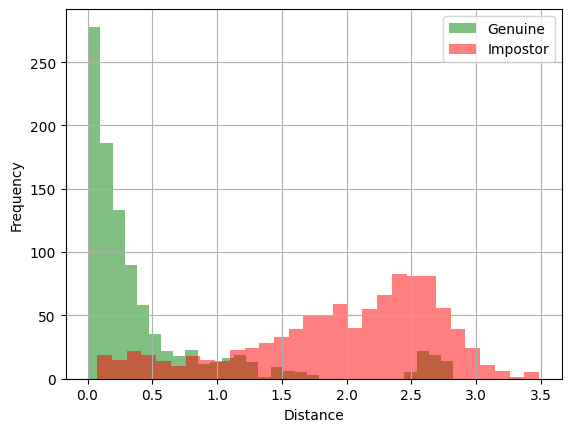

EER: 0.069
Epoch: 259 / Loss: 0.028149684735884268


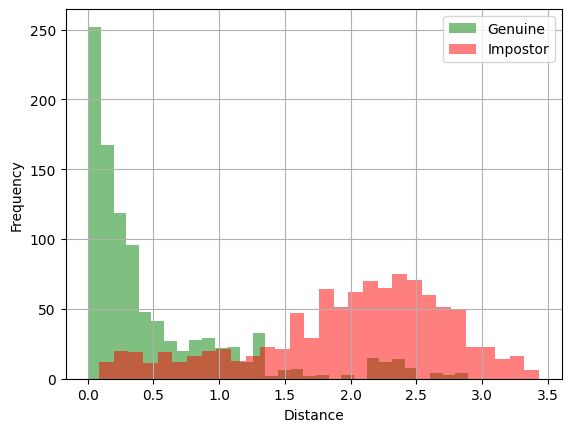

EER: 0.0745
Epoch: 269 / Loss: 0.02395643076548974


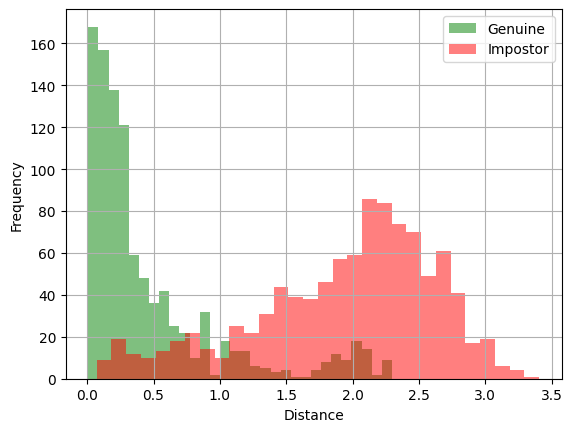

EER: 0.063
Epoch: 279 / Loss: 0.01401140990977486


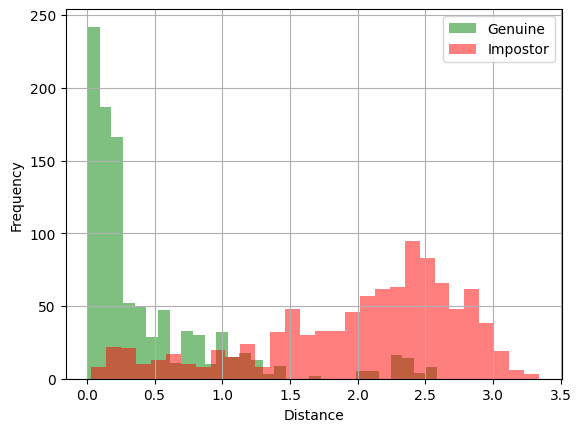

EER: 0.0615
Epoch: 289 / Loss: 0.018901246289412182


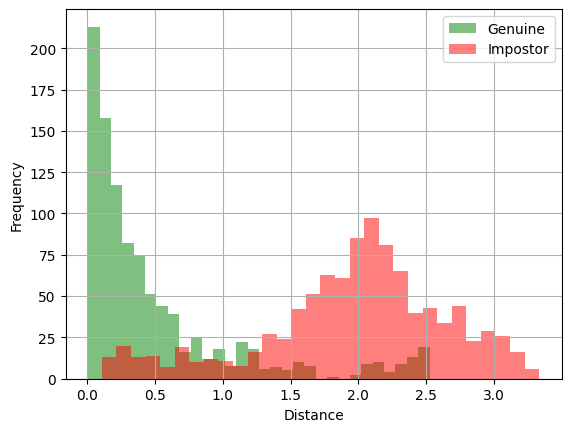

EER: 0.0625
Epoch: 299 / Loss: 0.010284145595505834


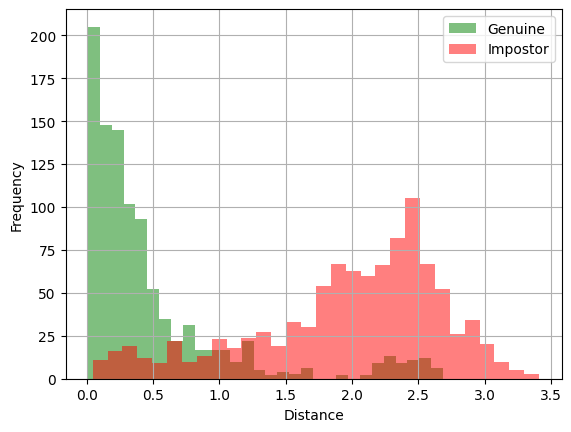

EER: 0.065


In [ ]:
model = torchvision.models.resnet.resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=64, bias=True)
model = model.cuda()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50, num_workers=2, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

triplet_loss = torch.nn.TripletMarginLoss(margin=1.0)

for epoch in range(300):
  loss_sum = 0
  model.train()
  for x, y, z in train_dataloader:
    x = torch.cat((x,x,x), dim=1).cuda()
    y = torch.cat((y,y,y), dim=1).cuda()
    z = torch.cat((z,z,z), dim=1).cuda()

    optimizer.zero_grad()

    feat_x = torch.nn.functional.normalize(model(x), p=2.0, dim=1)
    feat_y = torch.nn.functional.normalize(model(y), p=2.0, dim=1)
    feat_z = torch.nn.functional.normalize(model(z), p=2.0, dim=1)

    loss = triplet_loss(feat_x, feat_y, feat_z)
    loss_sum += loss.item()*len(x)

    loss.backward()
    optimizer.step()
  loss_sum /= len(train_dataset)

  if epoch%10 == 9:
    print('Epoch:', epoch, '/ Loss:', loss_sum)
    model.eval()

    genuine = []
    impostor = []
    for j in range(10):
      for i, (x, y, z) in enumerate(test_dataloader):
        x = torch.cat((x,x,x), dim=1).cuda()
        y = torch.cat((y,y,y), dim=1).cuda()
        z = torch.cat((z,z,z), dim=1).cuda()

        with torch.no_grad():
          feat_x = torch.nn.functional.normalize(model(x), p=2.0, dim=1)
          feat_y = torch.nn.functional.normalize(model(y), p=2.0, dim=1)
          feat_z = torch.nn.functional.normalize(model(z), p=2.0, dim=1)

        genuine.append(torch.sum((feat_x-feat_y)**2).item())
        impostor.append(torch.sum((feat_x-feat_z)**2).item())

    plt.hist(genuine, bins=30, alpha=0.5, label='Genuine', color='green')
    plt.hist(impostor, bins=30, alpha=0.5, label='Impostor', color='red')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('EER:', equal_error_rate(genuine, impostor))